INPUTS
- `sset.PATH_CIAM_COASTLINES_BY_ISO`
- `sset.PATH_CIAM_SITES_VORONOI_BY_ISO`

OUTPUTS
- `sset.PATH_CIAM_COASTLINES_BY_CIAM_SITE`

In [1]:
%load_ext autoreload

%autoreload 2

import geopandas as gpd

from sliiders import spatial as pv
from sliiders import settings as sset

pv.filter_spatial_warnings()

### Read site (point) ISO-level Voronoi, ISO-level coastlines

In [6]:
site_vor = gpd.read_parquet(sset.PATH_CIAM_SITES_VORONOI_BY_ISO).set_crs(epsg=4326)
coastlines = gpd.read_parquet(sset.PATH_CIAM_COASTLINES_BY_ISO).set_crs(epsg=4326)

coastlines = coastlines.drop(columns=["line_id"]).dissolve("ISO")

### Join coastlines to CIAM site Voronoi

In [7]:
coastlines = coastlines.rename(columns={"geometry": "coastline"})

site_vor = site_vor.join(coastlines, on="ISO", how="left")

assert site_vor["ISO"].isnull().sum() == 0

#### Clip coastal segments within point-based Voronoi shapes

In [8]:
site_vor["segment"] = site_vor["coastline"].intersection(site_vor["geometry"])

CPU times: user 2min 7s, sys: 7.78 ms, total: 2min 7s
Wall time: 2min 7s


In [9]:
coastal_segs = site_vor.drop(columns=["geometry", "coastline"]).rename(
    columns={"segment": "geometry"}
)

### Aggregate MultiLineStrings where possible

In [10]:
coastal_segs["geometry"] = coastal_segs["geometry"].apply(pv.grab_lines)

### Save

In [15]:
coastal_segs.to_parquet(sset.PATH_CIAM_COASTLINES_BY_CIAM_SITE, index=False)

### View

<AxesSubplot:>

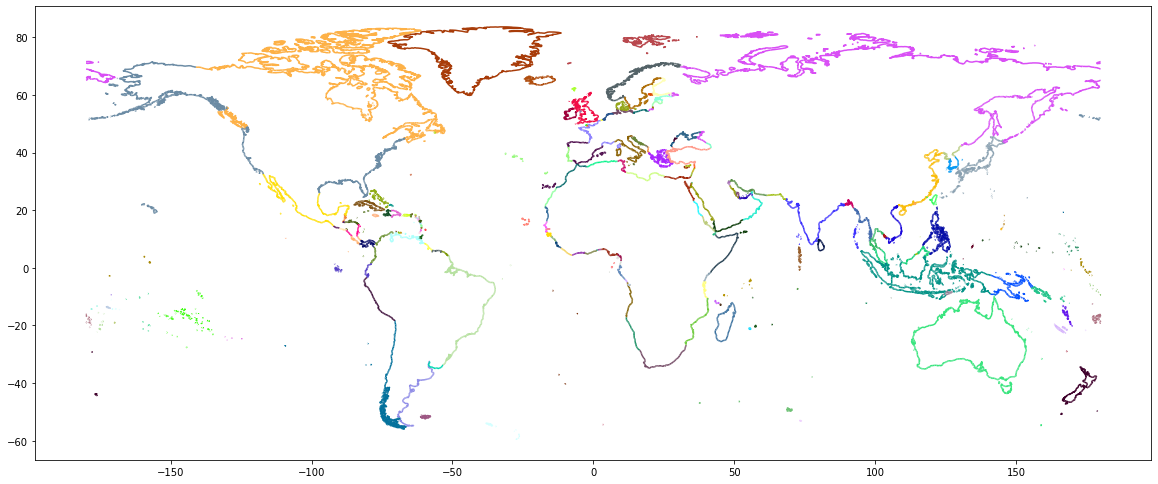

In [18]:
coastal_segs["color"] = pv.add_rand_color(coastal_segs, "ISO")

coastal_segs.plot(color=coastal_segs["color"], figsize=(20, 20))